# Reading raw files

For illustration, we will use files from Uapishka test deployment. In the project directory, there are two raw data files, measured consecutive - `example_ua1.gz` and `example_ua2.gz`. This type of data can be read using the `MISTData.read_raw()` method.

In [1]:
import numpy as np

from mistdata import MISTData

data1 = MISTData.read_raw("example_ua1.gz")

# Exploring MIST data class

The `MISTData` class contains three other classes - `DUTRecIn`, `DUTLNA` and `Spectrum`, which represent three separate sets of measurements:
1) `DUTRecIn` ("Device under test: receiver input") is stored in `MISTDATA.dut_recin` field.
2) `DUTLNA` ("Device under test: low noise amplifier") is stored in `MISTDATA.dut_lna` field.
3) `Spectrum` is stored in `MISTDATA.spec` field.

All three classes also include measurements from instrument thermistors in a separate `Thermistors` class. It is stored in a `therm` field, so let's say, if you want to access
thermistor measurements for LNA, use `MISTData.dut_lna.therm`. 

## Thermistors

Thermistors always include a timestamp (`datetime` object) and measurements:
- `Thermistors.lna` - from LNA
- `Thermistors.vna_load` - from vector network analyzer (VNA) load
- `Thermistors.ambient_load` - from ambient noise load
- `Thermistors.back_end` - from back-end

The `Thermistors` values will be single floats in the case of a single data file, but in the case of several data files combined `, Thermistors` will contain arrays of values.

In [2]:
therm = data1.dut_lna.therm
print(therm.time.strftime("Time: %H:%M:%S on %B %d, %Y"))

# Thermistors show zero temperature because this particular data was
# not taken during Uapishka deployment
print(f"Temp. at LNA: {therm.lna} K")
print(f"Temp. at VNA: {therm.vna_load} K")

Time: 16:48:24 on August 08, 2021
Temp. at LNA: 0.0 K
Temp. at VNA: 0.0 K


## DUTRecIn

Apart from thermistors measurements, the `DUTRecIn` contains $S_{11}$ data for different standarts of relative calibration:
- `DUTRecIn.s11_open` - measured with open standard;
- `DUTRecIn.s11_short` - measured with short standard;
- `DUTRecIn.s11_match` - $S_{11}$ of a matched load (50 Ohms);
- `DUTRecIn.s11_antenna` - antenna $S_{11}$;
- `DUTRecIn.s11_ambient` - $S_{11}$ of ambient noise;
- `DUTRecIn.s11_noise_source` - $S_{11}$ of noise source;

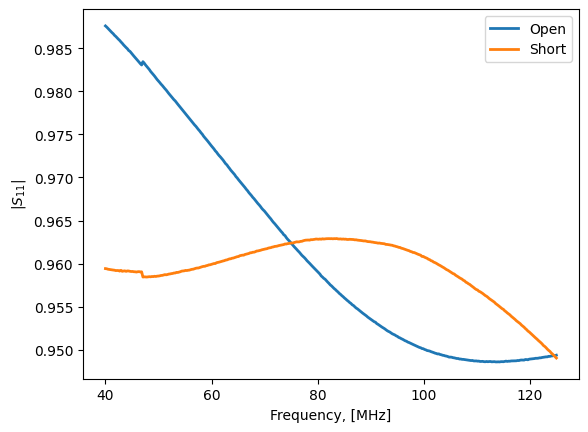

In [3]:
import matplotlib.pyplot as plt

rec = data1.dut_recin
plt.plot(rec.s11_freq, np.abs(rec.s11_open), lw=2, label="Open")
plt.plot(rec.s11_freq, np.abs(rec.s11_short), lw=2, label="Short")
plt.ylabel(r"$|S_{11}|$")
plt.xlabel("Frequency, [MHz]")
plt.legend()
plt.show()

## DUTLNA

Same applies to `DUTLNA` class - it contains $S_{11}$ measurements, but instead of antenna, ambient and noise source $S_{11}$, it contains the LNA $S_{11}$:
- `DUTRecIn.s11_open` - measured with open standard;
- `DUTRecIn.s11_short` - measured with short standard;
- `DUTRecIn.s11_match` - $S_{11}$ of a matched load (50 Ohms);
- `DUTRecIn.s11_lna` - LNA $S_{11}$.


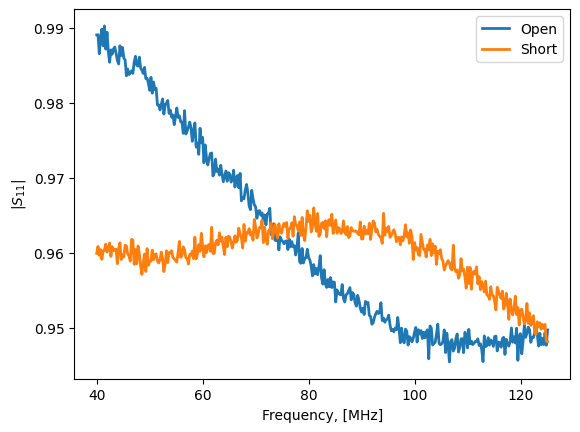

In [4]:
lna = data1.dut_lna
plt.plot(lna.s11_freq, np.abs(lna.s11_open), lw=2, label="Open")
plt.plot(lna.s11_freq, np.abs(lna.s11_short), lw=2, label="Short")
plt.ylabel(r"$|S_{11}|$")
plt.xlabel("Frequency, [MHz]")
plt.legend()
plt.show()

## Spectrum

The `Spectrum` class cotains the following set of data arrays:
- `Spectrum.therm` - thermistors measurements;
- `Spectrum.freq` - frequency axis;
- `Spectrum.psd_antenna` - the power spectral density (PSD) of the antenna;
- `Spectrum.psd_ambient` - ambient PSD;
- `Spectrum.psd_noise_source` - noise source PSD;

I also has timestamps of psd measurements in field `psd_antenna_time`, `psd_ambient_time`, `psd_noise_source_time`. The time of the beginning and the end of measurements are recorded separately in `time_start` and `time_end` fields.

The `Spectrum` class also contains a set of useful methods, for example, plotting functions. This inlcudes functions to plot PSDs:
- `plot_psd_antenna()`
- `plot_psd_ambient()`
- `plot_psd_noise_source()`

Let's take a look at the antenna PSD:

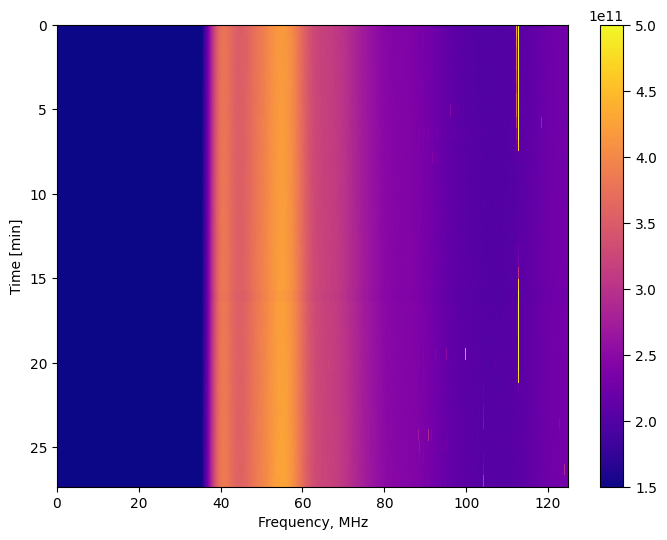

In [5]:
spec1 = data1.spec
spec1.plot_psd_antenna(vmin=1.5e11, vmax=5e11)
plt.show()

The `Spectrum` had an implemented method `calc_temp()` for an initial data calibration using ambient and ambient + noise source measurements. The temperature then can be plotted with `plot_temp()`:

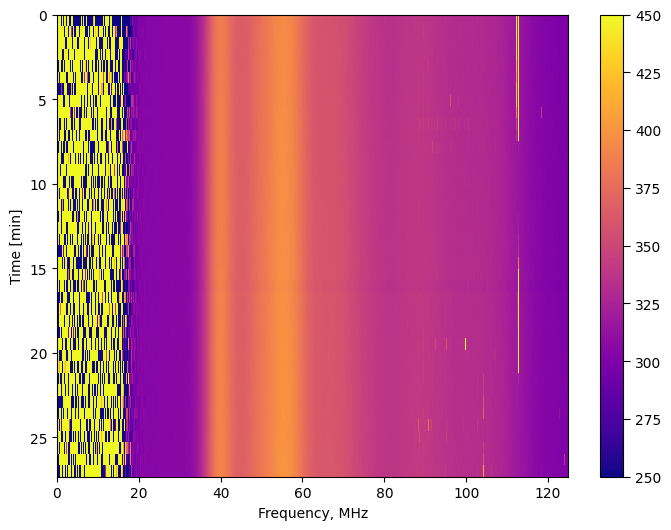

In [6]:
spec1.calc_temp() # Calculates the temperature and stores it in the Spectrum.temp
spec1.plot_temp(vmin=250, vmax=450)
plt.show()

Two more plotting functions are implemented in the `Spectrum` class: `plot_psd_antenna_rows()` and `plot_psd_antenna_stats()`, which allow studying antenna PSD profiles and statistics correspondingly:

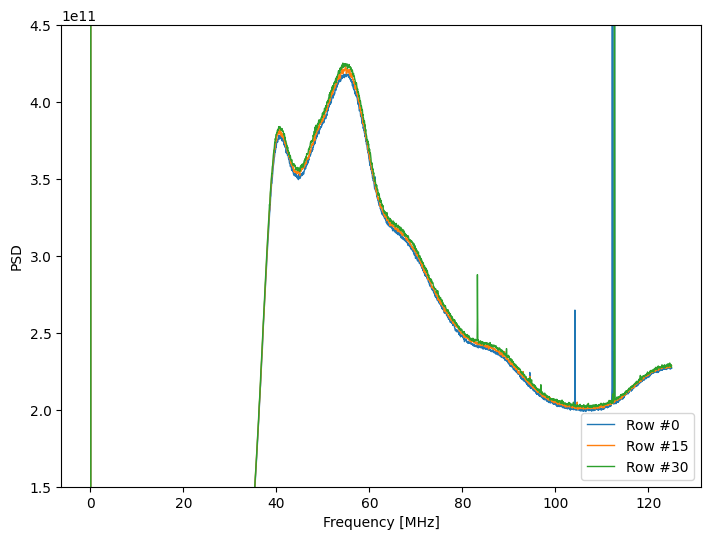

In [7]:
spec1.plot_psd_antenna_rows([0, 15, 30], vmin=1.5e11, vmax=4.5e11)
plt.show()

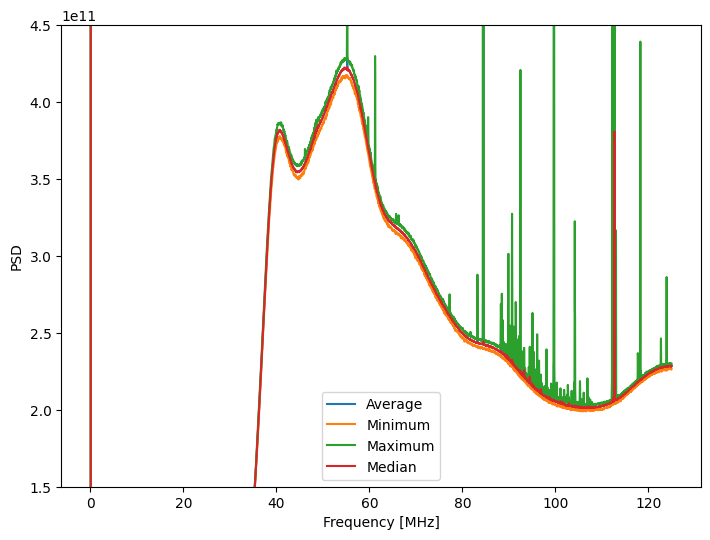

In [8]:
spec1.plot_psd_antenna_stats(vmin=1.5e11, vmax=4.5e11)
plt.show()

# Working with data

## Combining data

It is possible to merge two `MISTdata` instances by simply adding them. This operation automatically sorts all data using the timestamps and returns a new `MISTData` instance with combined data.

The `read_raw()` method can take an array of paths to raw data files as an input. In that case, the output will be a list of `MISTData` instances. You can also use the `nproc` parameter to specify the number of cores to use for data reading - useful if you are working with many files

In [9]:
from mistdata import MISTData

data1, data2 = MISTData.read_raw(["example_ua1.gz", "example_ua2.gz"], nproc=2)

data = data1 + data2

print(f"Data file #1\nStart:\t{data1.spec.time_start}\nEnd:\t{data1.spec.time_end}\n")
print(f"Data file #2\nStart:\t{data2.spec.time_start}\nEnd:\t{data2.spec.time_end}\n")
print(f"Merged data\nStart:\t{data.spec.time_start}\nEnd:\t{data.spec.time_end}\n")

Reading data files: 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

Data file #1
Start:	2021-08-08 16:49:13
End:	2021-08-08 17:16:33

Data file #2
Start:	2021-08-08 17:18:58
End:	2021-08-08 17:29:21

Merged data
Start:	2021-08-08 16:49:13
End:	2021-08-08 17:29:21


If you have many files, you can simply use `sum()` to merge them all together.

In [10]:
data = data1 + data2
data_sum = sum([data1, data2])
data == data_sum

True

## Spectrum slicing

The `Spectrum` class has slicing operation implemented. However, it is applied only to the `Spectrum` `psd_antenna`, `psd_ambient` and `psd_noise_source` arrays. The result of slicing is a new `Spectrum` instance. You can use it, for example, to cut off the spectrum rows you don't need. For example, let's cut off the bad data at the end of the combined Uapishka observations.

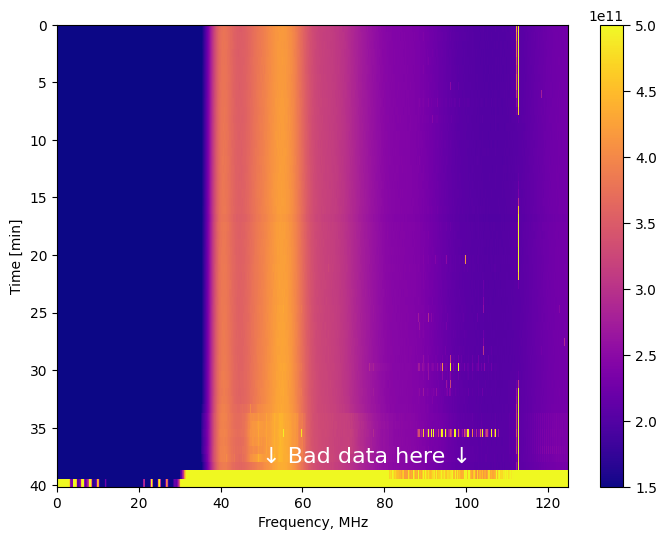

In [11]:
plot_kwargs = dict(vmin=1.5e11, vmax=5e11)
data.spec.plot_psd_antenna(**plot_kwargs)
plt.text(50, 38, "↓ Bad data here ↓", fontsize=16, c='w')
plt.show()

First, let's find out at which index does data become unusable. For this we can replot the spectrum with `plot_index` parameter turned on.

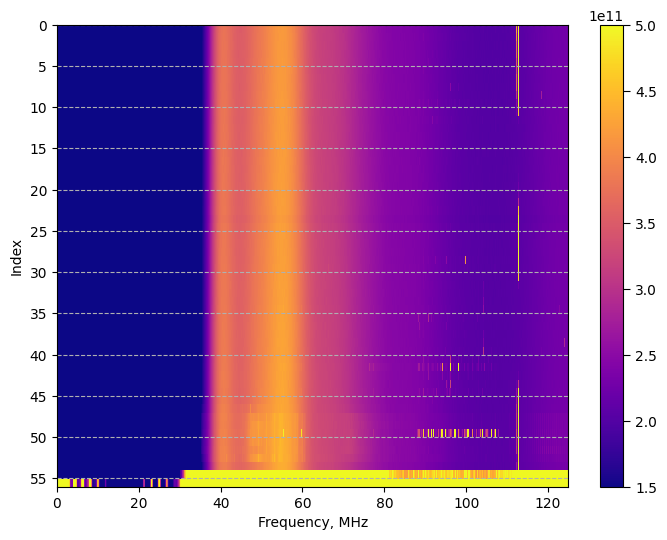

In [12]:
data.spec.plot_psd_antenna(**plot_kwargs, plot_index=True)
plt.show()

Seems like we should drop data starting from 54th row! Now let's do the slicing.

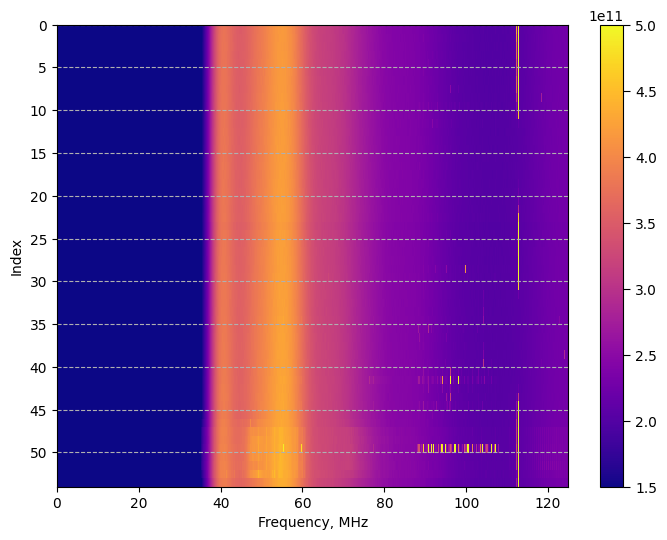

In [13]:
sliced_data = data[:54]
sliced_data.spec.plot_psd_antenna(**plot_kwargs, plot_index=True)
plt.show()

Here we applied slicing to the `MISTData` instance, but under the hood it was only applied to the `Spectrum` instance; all other data, such as Thermistors, DUTRecIn, DUTLNA remained untouched. You can also apply slicing directly to the `Spectrum` instances.

## HDF files

The `MISTData` class has a possibility of writng itself to the HDF file. This type of file is easier to comprehend (since all data is structured and has names) and much faster to read from disk. As an example, let's save the processed joined data from the last example.

In [14]:
sliced_data.save("uapishka_sliced")

The data is now saved in the `uapishka_sliced.mist` file. Reading the file is also simple - just call the `MISTData.load()` method. You may or may not specify the file extension.

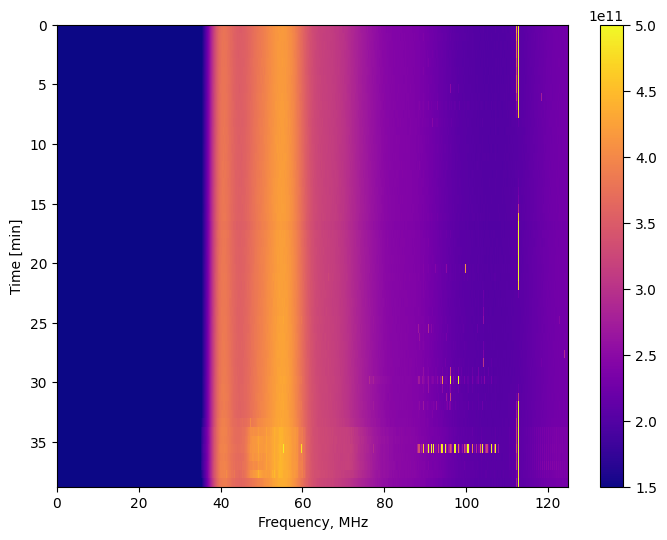

In [15]:
data_hdf = MISTData.load("uapishka_sliced")
data_hdf.spec.plot_psd_antenna(**plot_kwargs)
plt.show()